In [15]:
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
import numpy as np
from PIL import Image
import os

In [16]:
from geo_data import create_anchor_transform
from libs.ConvNeXt.models.convnext import ConvNeXt
import matplotlib.pyplot as plt
imap = plt.imread("europe.png")

In [4]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
trans = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

COORD_REF = np.array((50, 10))

In [17]:
device = torch.device("cuda")
model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], num_classes=2)

# model.load_state_dict(torch.load("logs/latlng_final/checkpoint-best.pth", map_location='cpu')['model'], strict=False)
# model.load_state_dict(torch.load("logs/latlng_pre/checkpoint-0.pth", map_location='cpu')['model'], strict=False)
# model.load_state_dict(torch.load("logs/latlng_raw/checkpoint-0.pth", map_location='cpu')['model'], strict=False)
model.load_state_dict(torch.load("logs/latlng_pre_colab/checkpoint-5.pth", map_location='cpu')['model'], strict=False)


model.to(device)
model.eval()

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): GELU(approximate=none)
        (pwconv2): Linear(in_features=512, out_features=128, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), p

In [67]:
@torch.no_grad()
def pred_latlng(img_path):
    _, coord = img_path[:-4].split("_")
    lat, lng = coord.split(",")
    latlng = np.array([float(lat), float(lng)])
    
    img = Image.open(os.path.join(data_path, img_path))
    img_tensor = trans(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    pred = model(img_tensor)*10
    pred = pred.squeeze()
    return pred.detach().cpu().numpy()+COORD_REF, latlng

In [68]:
from tqdm import tqdm_notebook
from geo_data import build_geo_dataset

In [69]:
data_path = "./eval"

reals, preds = [], []

errors = []
for fname in os.listdir("./eval"):
    pred, real = pred_latlng(fname)
    reals.append(real)
    preds.append(pred)
    errors.append(np.linalg.norm(real - pred))

reals = np.array(reals)
preds = np.array(preds)
errors = np.array(errors)

In [70]:
errors[errors<5].mean()

2.835671880953881

60


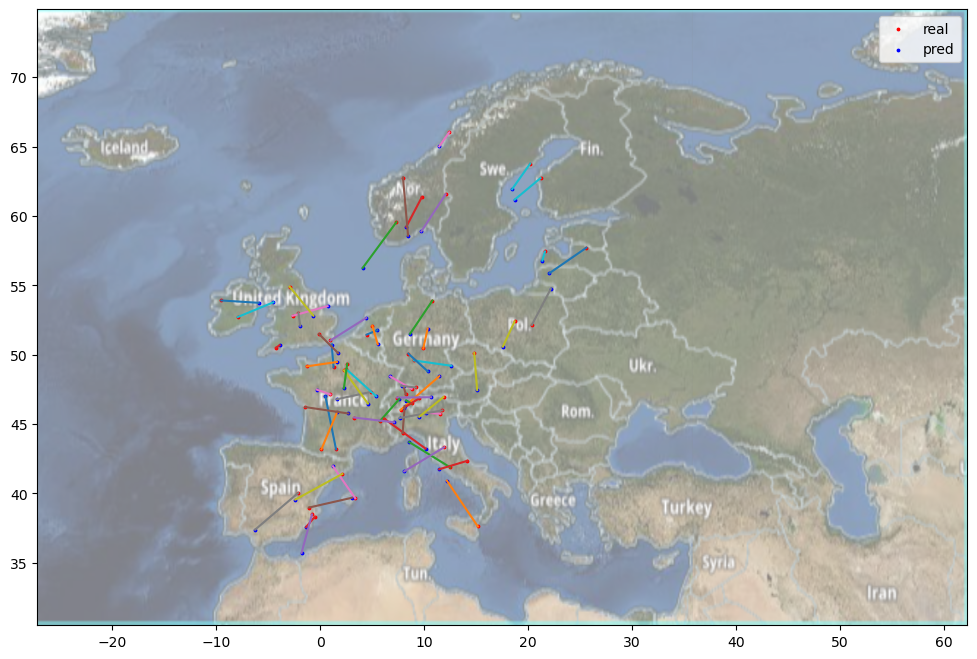

In [71]:
plt.rcParams["figure.figsize"] = (12,8)
choice_inds = errors<5
print(np.count_nonzero(choice_inds))
plt.scatter(reals[choice_inds, 1], reals[choice_inds,0], c='r', label='real', s=3)
plt.scatter(preds[choice_inds, 1], preds[choice_inds,0], c='b', label='pred', s=3)

for c1, c2 in zip(preds[choice_inds], reals[choice_inds]):
    plt.plot([c1[1], c2[1]], [c1[0], c2[0]])
    
plt.imshow(imap, alpha=0.5, aspect='auto', extent=[-27.17555, 62.23576, 30.49074, 74.90111])
plt.legend()
plt.show()

40


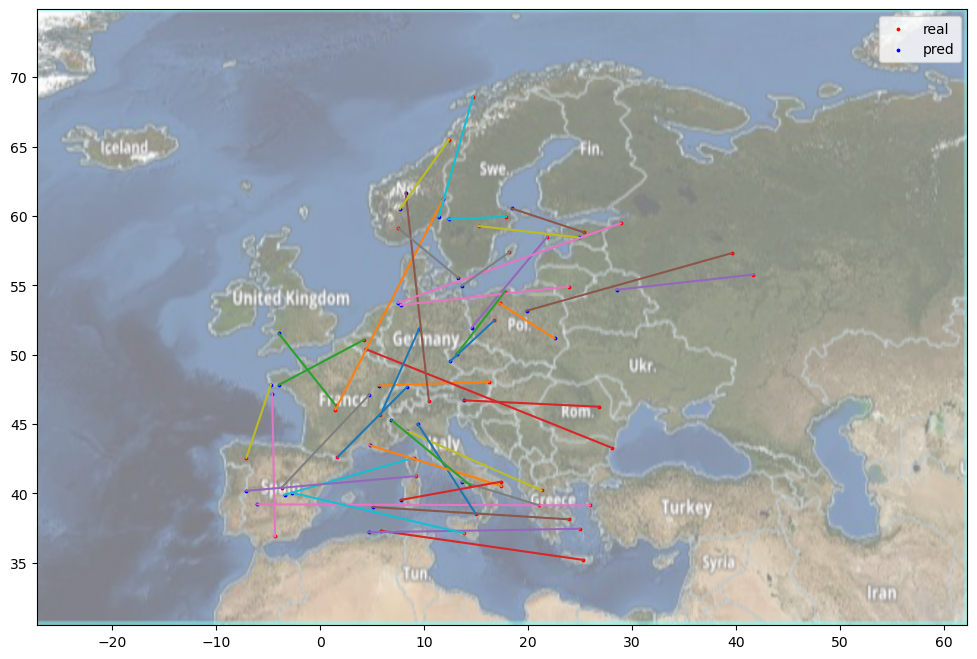

In [72]:
choice_inds = errors>5
print(np.count_nonzero(choice_inds))
plt.scatter(reals[choice_inds, 1], reals[choice_inds,0], c='r', label='real', s=3)
plt.scatter(preds[choice_inds, 1], preds[choice_inds,0], c='b', label='pred', s=3)

for c1, c2 in zip(preds[choice_inds], reals[choice_inds]):
    plt.plot([c1[1], c2[1]], [c1[0], c2[0]])
plt.imshow(imap, alpha=0.5, aspect='auto', extent=[-27.17555, 62.23576, 30.49074, 74.90111])
plt.legend()
plt.show()

In [60]:
errors

array([ 7.20835589,  2.84313316,  5.55707781,  2.56548754, 19.02708431,
        1.24634707,  0.53127246,  2.48945026,  6.82807764,  1.88501943,
        1.53378365,  1.22678743,  5.92770819,  2.09536807,  3.53486246,
        0.24471859,  3.10324808,  3.78696975, 18.81979322,  6.58660205,
       13.48222651, 16.00292779,  1.67911382, 11.10882005, 15.66623244,
        9.50161022, 10.84420739,  7.57632886,  7.1940092 ,  4.73971658,
        6.98405399,  6.9721744 ,  3.24739538,  2.03561617,  4.70889912,
        8.28880159,  6.38053346, 10.28147185,  7.25673775,  3.99218603,
        6.24568359,  3.37881833,  4.02047289,  4.35746172,  3.09819343,
        1.31795639,  0.79612789,  1.62926697,  3.77084007,  7.86669115,
        9.28119014,  3.35787138,  1.75878592, 24.93811836, 18.68190953,
        2.61353054, 18.06645061,  2.12926215,  6.99387229,  7.3905097 ,
       13.04700806,  3.5104084 , 13.11598359, 18.19744352,  3.81042461,
        2.38972408, 10.18691465,  0.803674  ,  1.82404894,  2.27

In [55]:
@torch.no_grad()
def pred_N_show(img_path):
    img = Image.open(img_path).convert("RGB")
#     print(img.size)
    img_tensor = trans(img).to(device)
    img_tensor = img_tensor.unsqueeze(0)
    
    pred = model(img_tensor)*10
    pred = pred.squeeze()
    coord = pred.detach().cpu().numpy()+COORD_REF
    print(coord)
    plt.rcParams["figure.figsize"] = (11,4)
    
    fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [3, 2]})
    ax1.scatter([coord[1]], coord[0], c='r', label='real', s=5)
    
    ax1.imshow(imap, alpha=0.5, aspect='auto', extent=[-27.17555, 62.23576, 30.49074, 74.90111])
    ax2.imshow(plt.imread(img_path), aspect='auto')
    plt.show()
    

[49.11320746 21.13178825]


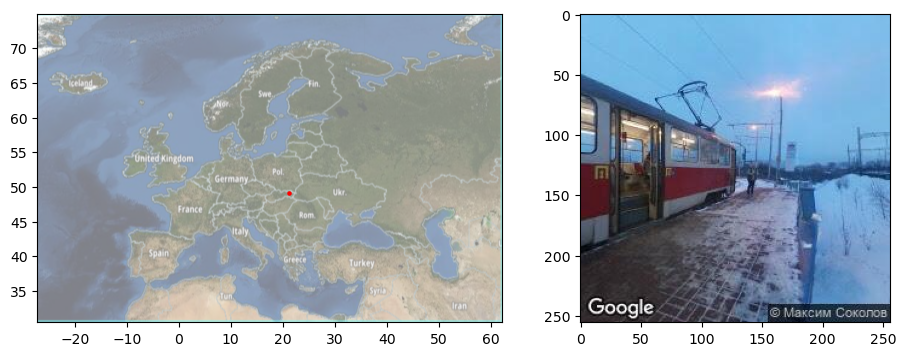

In [56]:
pred_N_show("./demo/1.png")

[47.88610291  0.47000027]


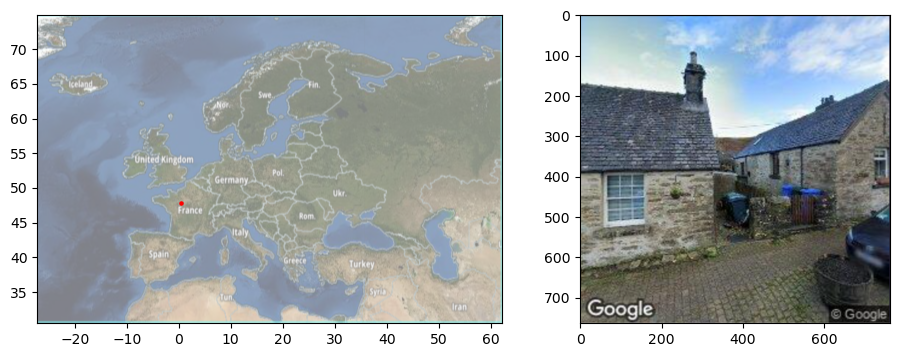

In [57]:
pred_N_show("./demo/2.png")

[39.54220581 20.68409061]


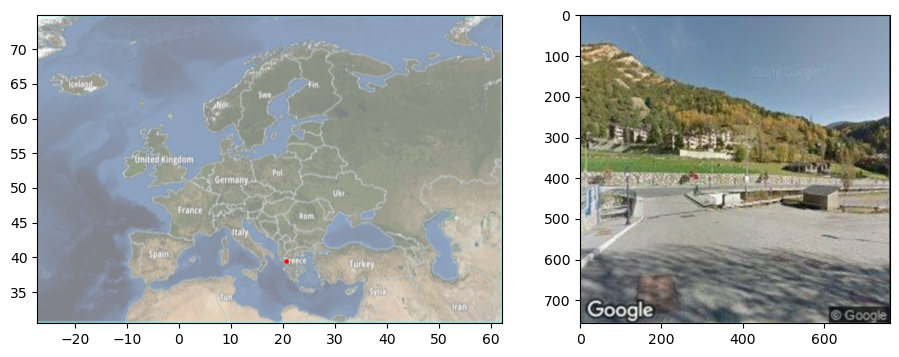

In [58]:
pred_N_show("./demo/3.png")

[43.8645277  1.6268959]


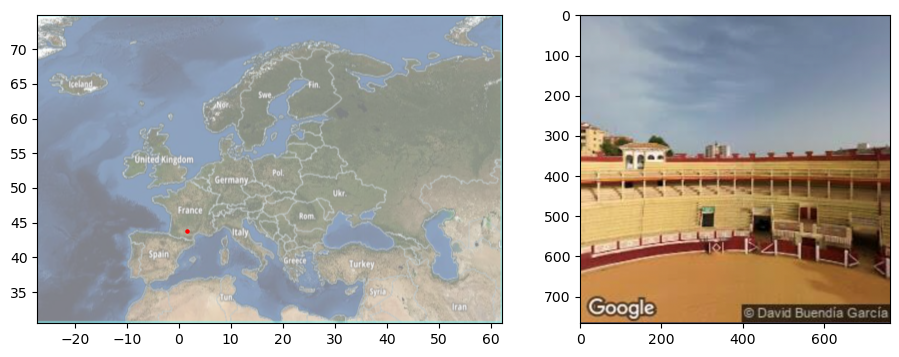

In [59]:
pred_N_show("./demo/4.png")

[45.47573948  3.51606274]


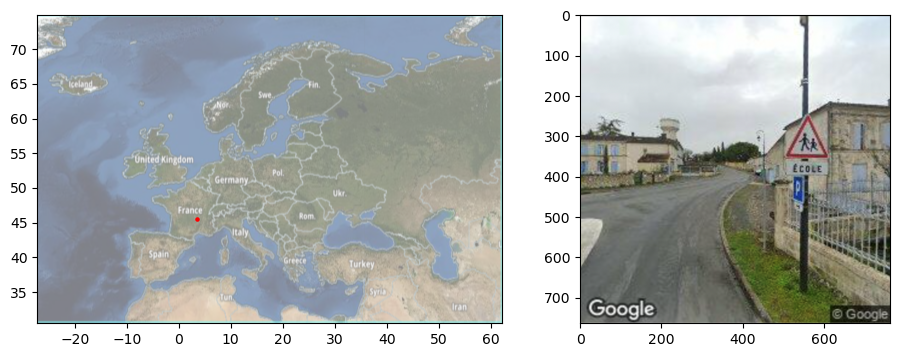

In [60]:
pred_N_show("./demo/5.png")

[50.92797148 21.76567554]


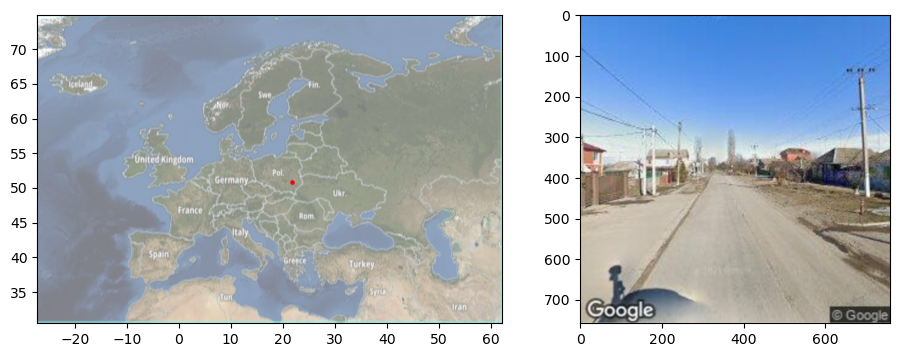

In [61]:
pred_N_show("./demo/0a61816da7bb50b47a772732dec0b2e.png")